In [1]:
%load_ext autoreload

In [3]:
%autoreload

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import color.data.dataset as color_dataset
import color.utils.utils as utils

In [4]:
# Get colors dataset
dataset = color_dataset.Dataset(dataset='small', emb_len=50, max_words=3, pad_len=3)

Loading colors dataset
Loading embeddings
Padding embeddings for color names
Splitting dataset


In [5]:
class ColorPredictorCNN(nn.Module):

    def __init__(self, **kwargs):
        super(ColorPredictorCNN, self).__init__()
        self.params = {
            'emb_dim': 50,
            'num_emb': 3,
            'color_dim': 3,
            'num_conv_layers': 2, 
            'conv_kernel_size': 5,
            'conv_stride': 1, 
            'pool_kernel_size': 2,
            'pool_stride': 2,
            'num_linear_layers': 2,
            'linear_size_dim': 2
        }
        self.params.update(kwargs)

        self.conv_layers = []
        self.pool_layers = []
        inp_len, inp_channels, out_channels = (
            self.params['emb_dim'], self.params['num_emb'], self.params['num_emb'] * 2)
        for l in range(self.params['num_conv_layers']):
            conv = nn.Conv1d(inp_channels, out_channels,
                             kernel_size=self.params['conv_kernel_size'],
                             stride=self.params['conv_stride'])
            self.add_module('cnn{}'.format(l + 1), conv)
            self.conv_layers.append(conv)
            inp_len = int((inp_len - self.params['conv_kernel_size']) / self.params['conv_stride']) + 1
            inp_channels, out_channels = inp_channels*2, out_channels*2
            assert inp_len > 1
            
            pool = nn.MaxPool1d(self.params['pool_kernel_size'], stride=self.params['pool_stride'])
            self.add_module('pool{}'.format(l + 1), pool)
            self.pool_layers.append(pool)
            inp_len = int((inp_len - self.params['pool_kernel_size']) / self.params['pool_stride']) + 1
            assert inp_len > 1
        
        self.linear_layers = []
        in_feature = inp_len*inp_channels
        out_feature = round(in_feature / self.params['linear_size_dim'])
        for l in range(self.params['num_linear_layers']):
            assert out_feature >= 3
            linear = nn.Linear(in_feature, out_feature)
            self.add_module('linear{}'.format(l + 1), linear)
            self.linear_layers.append(linear)
            in_feature, out_feature = out_feature, round(out_feature/self.params['linear_size_dim'])
        out_feature = in_feature
        
        self.final_linear = nn.Linear(out_feature, self.params['color_dim'])
    
    def forward(self, emb):
        pool_out = emb
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            conv_out = conv(pool_out)
            pool_out = pool(conv_out)
        linear_in = pool_out.view(pool_out.shape[0], -1)
        for linear in self.linear_layers:
            linear_in = linear(linear_in)
        linear_out = self.final_linear(linear_in)
        return torch.sigmoid(linear_out)


In [6]:
# Just checking
m = ColorPredictorCNN()
print(m)
print(utils.get_trainable_params(m))
t = torch.Tensor(32,3,50)
m(t).shape

ColorPredictorCNN(
  (cnn1): Conv1d(3, 6, kernel_size=(5,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv1d(6, 12, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=108, out_features=54, bias=True)
  (linear2): Linear(in_features=54, out_features=27, bias=True)
  (final_linear): Linear(in_features=27, out_features=3, bias=True)
)
7923


torch.Size([32, 3])

In [7]:
# LSTM model with all hyper-parameters
class ColorPredictorSequenceModel(nn.Module):

    def __init__(self, **kwargs):
        super(ColorPredictorSequenceModel, self).__init__()
        
        # RNN model defaults
        self.params = {
            'name': 'rnn-name-predictor',  # Model name
            'model_type': 'RNN',  # One of (RNN, LSTM)
            'emb_dim': 50,  # Embedding dimensions
            'color_dim': 3,  # Color space dimensions, But don't change
            'hidden_dim': 50,  # No of neurons in each hidden layer
            'num_layers': 2,  # No of hidden layers
            'dropout': 0,  # Dropout factor
            'nonlinearity': 'relu'  # Only for RNN: Activation function: tanh, relu
        }
        utils.dict_update_existing(self.params, kwargs)

        # RNN Layer
        if self.params['model_type'] == 'RNN':
            self.rnn = nn.RNN(
                self.params['emb_dim'], self.params['hidden_dim'], num_layers=self.params['num_layers'],
                dropout=self.params['dropout'], nonlinearity=self.params['nonlinearity']
            )
        else:
            self.rnn = nn.LSTM(
                self.params['emb_dim'], self.params['hidden_dim'],
                num_layers=self.params['num_layers'], dropout=self.params['dropout']
            )

        # Final linear layer converts the last time step output of RNN to an RGB value
        self.linear = nn.Linear(self.params['hidden_dim'], self.params['color_dim'])


    def forward(self, emb):
        # Process color name embeddings with RNN
        rnn_out, _ = self.rnn(emb)

        # Extract last time step output
        final_out = rnn_out[-1]

        # Convert last time step output of RNN to an RGB value using linear layer
        linear_out = self.linear(final_out)

        # Scale output between 0 and 1 with sigmoid
        return torch.sigmoid(linear_out)

In [8]:
m = ColorPredictorSequenceModel()
print(utils.get_trainable_params(m))
t = torch.Tensor(1,3,50)
m(t).shape

10353


torch.Size([3, 3])

In [9]:
# Model Training
num_epochs = 5
model = ColorPredictorCNN().double()
# model = ColorPredictorSequenceModel().double()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)
loss_fn = nn.MSELoss()
losses = []
seq_len_first=False

# Initialize train loader
train_loader = color_dataset.DataLoader(
    dataset.train_set,
    seq_len_first=seq_len_first,
    use_cuda = False
)

# Train
for epoch in range(num_epochs):
    for i, (rgb, embedding, _) in enumerate(train_loader):
        model.zero_grad()
        rgb_preds = model(embedding)
        loss = loss_fn(rgb, rgb_preds)
        loss.backward()
        optimizer.step()
    print('Epoch Complete : {}'.format(epoch+1))
    losses.append(loss.detach().numpy())

Epoch Complete : 1
Epoch Complete : 2
Epoch Complete : 3
Epoch Complete : 4
Epoch Complete : 5


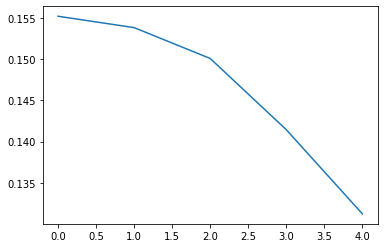

In [10]:
# Plot loss per epoch (should be going down)
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses)

[[0.6499260075905143, 0.6112694365043072, 0.5593206592510556], [0.6554975452527911, 0.6165979597666482, 0.5390809068212903]]


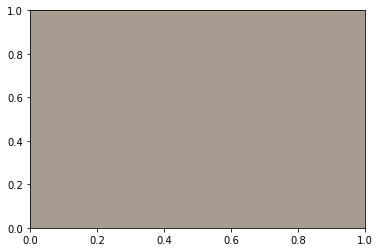

In [11]:
# Runs a new color name throught the model to predict its color
def predict(model, dataset, color_names, pad_len=None, seq_len_first=False):
    color_name_embs = []
    for name in color_names:
        emb = color_dataset.to_embeddings(name, dataset.vocab_dict, dataset.embeddings)
        
        if pad_len is not None:
            if emb.shape[0] <= pad_len:
                emb = np.pad(emb, ((0, pad_len - emb.shape[0]), (0, 0)), 'constant')
            else:
                raise AssertionError('Color name is longer than pad length')
                
        if seq_len_first:
            emb = emb.reshape(emb.shape[0], 1, -1)
        else:
            emb = emb.reshape(1, emb.shape[0], -1)
        
        color_name_embs.append(torch.DoubleTensor(emb))
            
    with torch.no_grad():
        preds = []
        for emb in color_name_embs:
            pred_rgb = model(emb)
            preds.append(torch.Tensor.tolist(pred_rgb.view(-1)))
        return preds
color_preds = predict(model, dataset, ['red brown', 'green'],
                      pad_len=dataset.params['pad_len'],
                      seq_len_first=seq_len_first)
print(color_preds)
p = patches.Rectangle((0,0), 5, 5, color=color_preds[0])
fig,ax = plt.subplots(1)
ax.add_patch(p)